<a href="https://colab.research.google.com/github/HyunwooLee0429/2LSPVSS/blob/main/MultiAIS_AB_random_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import library and data

In [ ]:
# To activate gurobi in colab, use the below code. This is one-time required.
!pip install gurobipy

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import random
from itertools import permutations
from gurobipy import *

## Make directory

In [ ]:
# If you want to use colab, just use the below code.
# If you want to use your jupyter notebook in your pc, you need to manually set the parent_dir
# parent_dir = '/Users/HWL/Dropbox/Virginia Tech/Research'
parent_dir = os.getcwd()

directory = 'Multi_AB'
path = os.path.join(parent_dir, directory)

if not os.path.exists(path):
  os.mkdir(path)

directory = ['Transfer_%d'%i for i in range(2,8)]
for direc in directory:
    path_new = os.path.join(path, direc)
    if not os.path.exists(path_new):
      os.mkdir(path_new)

## Generate Random dataset (You can adjust the probability and the weights)

In [ ]:
# 4 counties in total
counties = ['A', 'B', 'C', 'D']

# For each county, 10 lakes in total
num_lakes_per_county = 10

# Define probabilities for each county and infestation status
probabilities = {
    'A': {'zm2019': 0.3, 'ss2019': 0.3, 'ew2019': 0.3, 'sf2019': 0.3},
    'B': {'zm2019': 0.8, 'ss2019': 0.8, 'ew2019': 0.8, 'sf2019': 0.8},
    'C': {'zm2019': 0.1, 'ss2019': 0.1, 'ew2019': 0.1, 'sf2019': 0.1},
    'D': {'zm2019': 0.1, 'ss2019': 0.1, 'ew2019': 0.1, 'sf2019': 0.1},
}

# If you want to make the Single AIS case, choose one species and set the probability as 0 for the remaining species.
# probabilities = {
#     'A': {'zm2019': 0.3, 'ss2019': 0.0, 'ew2019': 0.0, 'sf2019': 0.0},
#     'B': {'zm2019': 0.8, 'ss2019': 0.0, 'ew2019': 0.0, 'sf2019': 0.0},
#     'C': {'zm2019': 0.1, 'ss2019': 0.0, 'ew2019': 0.0, 'sf2019': 0.0},
#     'D': {'zm2019': 0.1, 'ss2019': 0.0, 'ew2019': 0.0, 'sf2019': 0.0},
# }


# Step 1: Generate the list of lakes
lakes = [county + str(i) for county in counties for i in range(1, num_lakes_per_county + 1)]

# Step 2: Generate the dictionary for infestation status for each lake with probabilities
county_lakes = {}
for county in counties:
    county_lakes[county] = [county + str(i) for i in range(1, num_lakes_per_county + 1)]

AIS = ['zm2019', 'ss2019', 'ew2019', 'sf2019']

infestation_status = {}

for lake in lakes:
    infestation_status[lake] = {}

for county in counties:
    for species in AIS:
        tmp = random.sample(county_lakes[county], int(num_lakes_per_county*probabilities[county][species]))
        for lake in county_lakes[county]:
            if lake in tmp:
                infestation_status[lake][species] = 1
            else:
                infestation_status[lake][species] = 0

# Step 3: Generate all combinations of lakes to form pairs
# We assume that County A and B are closely located
lake_pairs = list(permutations(lakes, 2))
lake_pairs_close = [(lake1, lake2) for lake1 in county_lakes['A'] for lake2 in county_lakes['B']]

# Step 4: Generate DataFrame with randomly filled rows
data = []
for pair in lake_pairs:
    origin_lake, destination_lake = pair
    county_origin = origin_lake[0]
    county_destination = destination_lake[0]

    zm2019_origin = infestation_status[origin_lake]['zm2019']
    ss2019_origin = infestation_status[origin_lake]['ss2019']
    ew2019_origin = infestation_status[origin_lake]['ew2019']
    sf2019_origin = infestation_status[origin_lake]['sf2019']

    zm2019_destination = infestation_status[destination_lake]['zm2019']
    ss2019_destination = infestation_status[destination_lake]['ss2019']
    ew2019_destination = infestation_status[destination_lake]['ew2019']
    sf2019_destination = infestation_status[destination_lake]['sf2019']

    zm2019_risky= 1 if zm2019_origin == 1 and zm2019_destination == 0 else 0
    ss2019_risky = 1 if ss2019_origin == 1 and ss2019_destination == 0 else 0
    ew2019_risky = 1 if ew2019_origin == 1 and ew2019_destination == 0 else 0
    sf2019_risky = 1 if sf2019_origin == 1 and sf2019_destination == 0 else 0

    bij = zm2019_risky + ss2019_risky + ew2019_risky + sf2019_risky

    # Weights are randomly generated; Give more weights to the pairs which are close. This can be adjusted
    if pair in lake_pairs_close:
        weight = random.randint(10,20)
    else:
        weight = random.randint(0,1)

    data.append([
        origin_lake, destination_lake,
        weight,
        county_origin, zm2019_origin, ss2019_origin, ew2019_origin, sf2019_origin,
        county_destination, zm2019_destination, ss2019_destination, ew2019_destination, sf2019_destination,
        zm2019_risky, ss2019_risky, ew2019_risky, sf2019_risky, bij,
    ])

columns = ['dow_origin', 'dow_destination', 'weight', 'county_name.origin',
           'zm2019.origin', 'ss2019.origin', 'ew2019.origin', 'sf2019.origin',
           'county_name.destination', 'zm2019.destination', 'ss2019.destination',
           'ew2019.destination', 'sf2019.destination', 'zm2019.risky', 'ss2019.risky',
           'ew2019.risky', 'sf2019.risky', 'bij']

df_edge = pd.DataFrame(data, columns=columns)
df_edge.to_csv(path+'/df_edge.csv', index=True)

## Specify budget (You can adjust the budget for each county)

In [ ]:
# You can change budget. For the default, the budget is set as 1.
budget = 1

budge_count = {}

county_names = counties
for county in county_names:
    budge_count[county]= budget

## Option means the total budget of county A and county B (You can adjust the option)

In [ ]:
option=4

## Overview of the generated dataset

In [ ]:
df_edge

,dow_origin,dow_destination,weight,county_name.origin,zm2019.origin,ss2019.origin,ew2019.origin,sf2019.origin,county_name.destination,zm2019.destination,ss2019.destination,ew2019.destination,sf2019.destination,zm2019.risky,ss2019.risky,ew2019.risky,sf2019.risky,bij
0,A1,A2,1,A,0,1,0,0,A,1,0,1,0,0,1,0,0,1
1,A1,A3,1,A,0,1,0,0,A,0,1,0,1,0,0,0,0,0
2,A1,A4,0,A,0,1,0,0,A,0,0,1,0,0,1,0,0,1
3,A1,A5,0,A,0,1,0,0,A,0,0,0,1,0,1,0,0,1
4,A1,A6,1,A,0,1,0,0,A,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,D10,D5,0,D,1,0,0,0,D,0,0,0,0,1,0,0,0,1
1556,D10,D6,1,D,1,0,0,0,D,0,0,1,0,1,0,0,0,1
1557,D10,D7,1,D,1,0,0,0,D,0,1,0,0,1,0,0,0,1
1558,D10,D8,1,D,1,0,0,0,D,0,0,0,0,1,0,0,0,1


In [ ]:
infestation_status

{'A1': {'zm2019': 0, 'ss2019': 1, 'ew2019': 0, 'sf2019': 0},
 'A2': {'zm2019': 1, 'ss2019': 0, 'ew2019': 1, 'sf2019': 0},
 'A3': {'zm2019': 0, 'ss2019': 1, 'ew2019': 0, 'sf2019': 1},
 'A4': {'zm2019': 0, 'ss2019': 0, 'ew2019': 1, 'sf2019': 0},
 'A5': {'zm2019': 0, 'ss2019': 0, 'ew2019': 0, 'sf2019': 1},
 'A6': {'zm2019': 1, 'ss2019': 0, 'ew2019': 0, 'sf2019': 0},
 'A7': {'zm2019': 1, 'ss2019': 0, 'ew2019': 0, 'sf2019': 0},
 'A8': {'zm2019': 0, 'ss2019': 1, 'ew2019': 0, 'sf2019': 1},
 'A9': {'zm2019': 0, 'ss2019': 0, 'ew2019': 0, 'sf2019': 0},
 'A10': {'zm2019': 0, 'ss2019': 0, 'ew2019': 1, 'sf2019': 0},
 'B1': {'zm2019': 1, 'ss2019': 1, 'ew2019': 1, 'sf2019': 1},
 'B2': {'zm2019': 1, 'ss2019': 1, 'ew2019': 0, 'sf2019': 1},
 'B3': {'zm2019': 1, 'ss2019': 1, 'ew2019': 1, 'sf2019': 0},
 'B4': {'zm2019': 1, 'ss2019': 1, 'ew2019': 1, 'sf2019': 1},
 'B5': {'zm2019': 0, 'ss2019': 0, 'ew2019': 0, 'sf2019': 1},
 'B6': {'zm2019': 1, 'ss2019': 1, 'ew2019': 1, 'sf2019': 1},
 'B7': {'zm2019': 1, 's

In [ ]:
df_edge.describe()

,weight,zm2019.origin,ss2019.origin,ew2019.origin,sf2019.origin,zm2019.destination,ss2019.destination,ew2019.destination,sf2019.destination,zm2019.risky,ss2019.risky,ew2019.risky,sf2019.risky,bij
count,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000
mean,1.434615,0.325000,0.325000,0.325000,0.325000,0.325000,0.325000,0.325000,0.325000,0.225000,0.225000,0.225000,0.225000,0.900000
std,3.699880,0.468525,0.468525,0.468525,0.468525,0.468525,0.468525,0.468525,0.468525,0.417716,0.417716,0.417716,0.417716,1.124227
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


## Let's calculate w(v) for V.

In [ ]:
df_edge

,dow_origin,dow_destination,weight,county_name.origin,zm2019.origin,ss2019.origin,ew2019.origin,sf2019.origin,county_name.destination,zm2019.destination,ss2019.destination,ew2019.destination,sf2019.destination,zm2019.risky,ss2019.risky,ew2019.risky,sf2019.risky,bij
0,A1,A2,1,A,0,1,0,0,A,1,0,1,0,0,1,0,0,1
1,A1,A3,1,A,0,1,0,0,A,0,1,0,1,0,0,0,0,0
2,A1,A4,0,A,0,1,0,0,A,0,0,1,0,0,1,0,0,1
3,A1,A5,0,A,0,1,0,0,A,0,0,0,1,0,1,0,0,1
4,A1,A6,1,A,0,1,0,0,A,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,D10,D5,0,D,1,0,0,0,D,0,0,0,0,1,0,0,0,1
1556,D10,D6,1,D,1,0,0,0,D,0,0,1,0,1,0,0,0,1
1557,D10,D7,1,D,1,0,0,0,D,0,1,0,0,1,0,0,0,1
1558,D10,D8,1,D,1,0,0,0,D,0,0,0,0,1,0,0,0,1


## Lake weight rankings

In [ ]:
lakes = np.unique(np.concatenate((df_edge['dow_origin'].unique(),df_edge['dow_destination'].unique()),0))

In [ ]:
lake_county ={}

for lake in lakes:
    if len(df_edge[(df_edge['dow_origin']==lake)])!=0:
        lake_county[lake]=list(df_edge[(df_edge['dow_origin']==lake)]['county_name.origin'])[0]
    else:
        lake_county[lake]=list(df_edge[(df_edge['dow_destination']==lake)]['county_name.destination'])[0]

In [ ]:
w={}
for i in lakes:
    w[i]=0
for index,row in df_edge.iterrows():
    if row['bij'] != 0:
        w[row['dow_origin']] += row['bij']*row['weight']
        w[row['dow_destination']] += row['bij']*row['weight']

In [ ]:
w_sorted = dict(sorted(w.items(), key=lambda item: item[1], reverse=True))

In [ ]:
w_sorted

{'B5': 160,
 'B8': 135,
 'A8': 113,
 'B2': 97,
 'A3': 92,
 'B3': 91,
 'A2': 83,
 'B9': 81,
 'A1': 68,
 'A10': 68,
 'B4': 65,
 'A4': 64,
 'A7': 63,
 'B10': 61,
 'A5': 59,
 'A6': 56,
 'B1': 51,
 'B7': 50,
 'D4': 40,
 'A9': 37,
 'B6': 36,
 'C8': 36,
 'C2': 35,
 'C5': 35,
 'C7': 35,
 'D10': 34,
 'C3': 32,
 'D1': 32,
 'D5': 32,
 'D7': 32,
 'D6': 29,
 'D9': 29,
 'C1': 27,
 'C10': 23,
 'C4': 21,
 'D8': 21,
 'C9': 20,
 'C6': 19,
 'D2': 19,
 'D3': 17}

In [ ]:
county_lakes = {}

for county in county_names:
    county_lakes[county]=[]

for lake in lakes:
    county = list(df_edge[df_edge['dow_origin']==lake]['county_name.origin'])
    if len(county)!=0:
        county_lakes[county[0]].append(lake)
    else:
        county = list(df_edge[df_edge['dow_destination']==lake]['county_name.destination'])[0]
        county_lakes[county].append(lake)

## County weight rankings

In [ ]:
county_rankings = {}

for county in county_names:
    county_rankings[county]=0

for county in county_names:
    for lake in w_sorted:
        if lake in county_lakes[county]:
            county_rankings[county]+=w_sorted[lake]

In [ ]:
dict(sorted(county_rankings.items(), key=lambda item: item[1], reverse=True))

{'B': 827, 'A': 703, 'D': 285, 'C': 283}

## Inspection centers for each county are chosen in advance following the ranks

In [ ]:
weight_inf_within = {}
weight_inf_out = {}
weight_uninf_within = {}
weight_uninf_out = {}

weight_altruistic = {}
weight_altruistic_ct = {}
weight_selfish = {}
weight_selfish_ct = {}

for lake in lakes:
    weight_altruistic[lake]=0
    weight_selfish[lake]=0
    weight_inf_within[lake] = 0
    weight_inf_out[lake] = 0
    weight_uninf_within[lake] = 0
    weight_uninf_out[lake] = 0

for county in county_names:
    weight_altruistic_ct[county]={}
    weight_selfish_ct[county]={}

for index,row in df_edge.iterrows():
    if row['bij'] != 0:
        lake = row['dow_origin']
        county = lake_county[lake]
        if row['county_name.destination']==county:
            weight_inf_within[lake] += row['bij']*row['weight']
        else:
            weight_inf_out[lake] += row['bij']*row['weight']

        lake = row['dow_destination']
        county = lake_county[lake]
        if row['county_name.origin']==county:
            weight_uninf_within[lake] += row['bij']*row['weight']
        else:
            weight_uninf_out[lake] += row['bij']*row['weight']

for lake in lakes:
    weight_altruistic[lake] = weight_inf_within[lake] + weight_inf_out[lake] + weight_uninf_within[lake] + weight_uninf_out[lake]
    weight_selfish[lake] = weight_inf_within[lake] + weight_uninf_within[lake] + weight_uninf_out[lake]

for lake in lakes:
    weight_altruistic_ct[lake_county[lake]][lake] = weight_altruistic[lake]
    weight_selfish_ct[lake_county[lake]][lake] = weight_selfish[lake]

In [ ]:
weight_altruistic

{'A1': 68,
 'A10': 68,
 'A2': 83,
 'A3': 92,
 'A4': 64,
 'A5': 59,
 'A6': 56,
 'A7': 63,
 'A8': 113,
 'A9': 37,
 'B1': 51,
 'B10': 61,
 'B2': 97,
 'B3': 91,
 'B4': 65,
 'B5': 160,
 'B6': 36,
 'B7': 50,
 'B8': 135,
 'B9': 81,
 'C1': 27,
 'C10': 23,
 'C2': 35,
 'C3': 32,
 'C4': 21,
 'C5': 35,
 'C6': 19,
 'C7': 35,
 'C8': 36,
 'C9': 20,
 'D1': 32,
 'D10': 34,
 'D2': 19,
 'D3': 17,
 'D4': 40,
 'D5': 32,
 'D6': 29,
 'D7': 32,
 'D8': 21,
 'D9': 29}

In [ ]:
weight_selfish

{'A1': 30,
 'A10': 24,
 'A2': 14,
 'A3': 19,
 'A4': 24,
 'A5': 18,
 'A6': 21,
 'A7': 20,
 'A8': 19,
 'A9': 37,
 'B1': 7,
 'B10': 6,
 'B2': 51,
 'B3': 61,
 'B4': 4,
 'B5': 148,
 'B6': 4,
 'B7': 3,
 'B8': 107,
 'B9': 46,
 'C1': 27,
 'C10': 23,
 'C2': 28,
 'C3': 32,
 'C4': 21,
 'C5': 26,
 'C6': 19,
 'C7': 30,
 'C8': 26,
 'C9': 20,
 'D1': 32,
 'D10': 24,
 'D2': 19,
 'D3': 17,
 'D4': 27,
 'D5': 32,
 'D6': 20,
 'D7': 21,
 'D8': 21,
 'D9': 29}

### Sort the lakes by county

In [ ]:
# Sort Altruistic
for county in county_names:
    weight_altruistic_ct[county] = sorted(weight_altruistic_ct[county].items(), key=lambda item: item[1], reverse=True)

In [ ]:
# Sort Selfish
for county in county_names:
    weight_selfish_ct[county] = sorted(weight_selfish_ct[county].items(), key=lambda item: item[1], reverse=True)

In [ ]:
weight_altruistic_ct

{'A': [('A8', 113),
  ('A3', 92),
  ('A2', 83),
  ('A1', 68),
  ('A10', 68),
  ('A4', 64),
  ('A7', 63),
  ('A5', 59),
  ('A6', 56),
  ('A9', 37)],
 'B': [('B5', 160),
  ('B8', 135),
  ('B2', 97),
  ('B3', 91),
  ('B9', 81),
  ('B4', 65),
  ('B10', 61),
  ('B1', 51),
  ('B7', 50),
  ('B6', 36)],
 'C': [('C8', 36),
  ('C2', 35),
  ('C5', 35),
  ('C7', 35),
  ('C3', 32),
  ('C1', 27),
  ('C10', 23),
  ('C4', 21),
  ('C9', 20),
  ('C6', 19)],
 'D': [('D4', 40),
  ('D10', 34),
  ('D1', 32),
  ('D5', 32),
  ('D7', 32),
  ('D6', 29),
  ('D9', 29),
  ('D8', 21),
  ('D2', 19),
  ('D3', 17)]}

## Each county already made the decision choosing top risky lakes

In [ ]:
# top lakes
selected_each_county_alt = {}
selected_each_county_self = {}

for county in county_names:
    num = budge_count[county]
    selected_each_county_alt[county] = weight_altruistic_ct[county][:num]
    selected_each_county_self[county] = weight_selfish_ct[county][:num]

In [ ]:
selected_each_county_alt

{'A': [('A8', 113)], 'B': [('B5', 160)], 'C': [('C8', 36)], 'D': [('D4', 40)]}

In [ ]:
selected_each_county_self

{'A': [('A9', 37)], 'B': [('B5', 148)], 'C': [('C3', 32)], 'D': [('D1', 32)]}

## Let's focus on two counties

In [ ]:
countyA='A'
countyB='B'

In [ ]:
ct_focus = ['A','B']
ct_interest = list(county_names)

In [ ]:
data4 = df_edge[(df_edge['county_name.origin'].isin(ct_interest))&(df_edge['county_name.destination'].isin(ct_focus)) | (df_edge['county_name.origin'].isin(ct_focus))&(df_edge['county_name.destination'].isin(ct_interest))]

In [ ]:
data4

,dow_origin,dow_destination,weight,county_name.origin,zm2019.origin,ss2019.origin,ew2019.origin,sf2019.origin,county_name.destination,zm2019.destination,ss2019.destination,ew2019.destination,sf2019.destination,zm2019.risky,ss2019.risky,ew2019.risky,sf2019.risky,bij
0,A1,A2,1,A,0,1,0,0,A,1,0,1,0,0,1,0,0,1
1,A1,A3,1,A,0,1,0,0,A,0,1,0,1,0,0,0,0,0
2,A1,A4,0,A,0,1,0,0,A,0,0,1,0,0,1,0,0,1
3,A1,A5,0,A,0,1,0,0,A,0,0,0,1,0,1,0,0,1
4,A1,A6,1,A,0,1,0,0,A,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,D10,B6,1,D,1,0,0,0,B,1,1,1,1,0,0,0,0,0
1537,D10,B7,0,D,1,0,0,0,B,1,1,1,1,0,0,0,0,0
1538,D10,B8,0,D,1,0,0,0,B,0,0,1,1,1,0,0,0,1
1539,D10,B9,1,D,1,0,0,0,B,1,1,1,0,0,0,0,0,0


## Make new dataframe considering pre-determined inspection center

In [ ]:
pre_selected_alt = []
pre_selected_self = []

In [ ]:
for county in county_names:
    if county != countyA and county!= countyB:
        pre_selected_alt = pre_selected_alt + selected_each_county_alt[county]
        pre_selected_self = pre_selected_self + selected_each_county_self[county]

In [ ]:
data_alt = data4[(~data4['dow_origin'].isin(pre_selected_alt)) & (~data4['dow_destination'].isin(pre_selected_alt))]
data_self = data4[(~data4['dow_origin'].isin(pre_selected_self)) & (~data4['dow_destination'].isin(pre_selected_self))]

## Rankings for county of interest considering pre-determined inspection center

In [ ]:
df_ranks_alt = pd.DataFrame(columns= ['dow', 'total_weight', 'weight_inf_within', 'weight_uninf_within','weight_inf_outside','weight_uninf_outside', 'county'])
df_ranks_self = pd.DataFrame(columns= ['dow', 'total_weight', 'weight_inf_within', 'weight_uninf_within','weight_inf_outside','weight_uninf_outside', 'county'])

for county in ct_focus:
    for lake in county_lakes[county]:
        try:
            row = data4[data4['dow_origin']==lake]
            row = row.iloc[0]
            new_row = pd.DataFrame.from_dict([{'dow':row['dow_origin'], 'total_weight':weight_altruistic[lake], 'weight_inf_within': weight_inf_within[lake], 'weight_uninf_within': weight_uninf_within[lake], 'weight_inf_outside':weight_inf_out[lake], 'weight_uninf_outside':weight_uninf_out[lake], 'county':row['county_name.origin']}])
        except:
            row = data4[data4['dow_destination']==lake]
            row = row.iloc[0]
            new_row = pd.DataFrame.from_dict([{'dow':row['dow_destination'], 'total_weight':weight_altruistic[lake], 'weight_inf_within': weight_inf_within[lake], 'weight_uninf_within': weight_uninf_within[lake], 'weight_inf_outside':weight_inf_out[lake], 'weight_uninf_outside':weight_uninf_out[lake], 'county':row['county_name.destination']}])
        df_ranks_alt = pd.concat([df_ranks_alt, new_row])
df_ranks_alt = df_ranks_alt.sort_values(by=['total_weight'], ascending=False)

for county in ct_focus:
    for lake in county_lakes[county]:
        try:
            row = data4[data4['dow_origin']==lake]
            row = row.iloc[0]
            new_row = pd.DataFrame.from_dict([{'dow':row['dow_origin'], 'total_weight':weight_selfish[lake], 'weight_inf_within': weight_inf_within[lake], 'weight_uninf_within': weight_uninf_within[lake], 'weight_inf_outside': 'NA', 'weight_uninf_outside':weight_uninf_out[lake], 'county':row['county_name.origin']}])
        except:
            row = data4[data4['dow_destination']==lake]
            row = row.iloc[0]
            new_row = pd.DataFrame.from_dict([{'dow':row['dow_destination'], 'total_weight':weight_selfish[lake], 'weight_inf_within': weight_inf_within[lake], 'weight_uninf_within': weight_uninf_within[lake], 'weight_inf_outside': 'NA', 'weight_uninf_outside':weight_uninf_out[lake], 'county':row['county_name.destination']}])
        df_ranks_self = pd.concat([df_ranks_self, new_row])
df_ranks_self = df_ranks_self.sort_values(by=['total_weight'], ascending=False)

In [ ]:
df_ranks_alt[df_ranks_alt['county']==countyA].iloc[:50].to_csv(path+'/df_ranks_alt_%s.csv'%(str(countyA)), index=False)
df_ranks_alt[df_ranks_alt['county']==countyB].iloc[:50].to_csv(path+'/df_ranks_alt_%s.csv'%(str(countyB)), index=False)
df_ranks_self[df_ranks_self['county']==countyA].iloc[:50].to_csv(path+'/df_ranks_self_%s.csv'%(str(countyA)), index=False)
df_ranks_self[df_ranks_self['county']==countyB].iloc[:50].to_csv(path+'/df_ranks_self_%s.csv'%(str(countyB)), index=False)

## Optimization Model

### Sets

In [ ]:
# for entire lake, we use data4 first

origin_unique = data4['dow_origin'].unique()
destination_unique = data4['dow_destination'].unique()
IandJ = np.concatenate((origin_unique, destination_unique))
IandJ = np.unique(IandJ)

I = np.unique(np.concatenate((data4[data4['county_name.origin']==countyA]['dow_origin'].unique(),data4[data4['county_name.destination']==countyA]['dow_destination'].unique())))
J = np.unique(np.concatenate((data4[data4['county_name.origin']==countyB]['dow_origin'].unique(),data4[data4['county_name.destination']==countyB]['dow_destination'].unique())))

### Parameters

In [ ]:
arcs=[]
n={}
t={}

In [ ]:
for index in data4.index:
    n[data4.loc[index,'dow_origin'], data4.loc[index,'dow_destination']] = data4.loc[index,'weight']
    t[data4.loc[index,'dow_origin'], data4.loc[index,'dow_destination']] = data4.loc[index,'bij']

In [ ]:
arcs = list(n.keys())

In [ ]:
arcs_alt=[]
t_alt={}
n_alt={}

In [ ]:
for index in data_alt.index:
    t_alt[data_alt.loc[index,'dow_origin'], data_alt.loc[index,'dow_destination']] = data_alt.loc[index,'bij']
    n_alt[data_alt.loc[index,'dow_origin'], data_alt.loc[index,'dow_destination']] = data_alt.loc[index,'weight']

In [ ]:
arcs_alt = list(t_alt.keys())

In [ ]:
arcs_self=[]
t_self={}
n_self={}

In [ ]:
for index in data_self.index:
    t_self[data_self.loc[index,'dow_origin'], data_self.loc[index,'dow_destination']] = data_self.loc[index,'bij']
    n_self[data_self.loc[index,'dow_origin'], data_self.loc[index,'dow_destination']] = data_self.loc[index,'weight']

In [ ]:
arcs_self = list(t_self.keys())

### Varying Budget

In [ ]:
# option means the total budget for county A and county B

if option ==2:
    K=2
    B_set = [2]
elif option ==3:
    K=3
    B_set = [3]
elif option ==4:
    K=4
    B_set = [4]
elif option ==5:
    K=5
    B_set = [5]

### Optimization model

In [ ]:
def base_model(B):
    # Gurobi Model
    model = Model("Base model")

    # Decision variables
    x={}
    for i in IandJ:
        x[i] = model.addVar(vtype = GRB.BINARY,name="x[%s]"%str(i))

    u={}
    for arc in arcs:
        u[arc] = model.addVar(vtype = GRB.INTEGER,name="u[%s]"%str(arc))

    #constraints
    for arc in arcs:
        model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t[arc])

    model.addConstr( quicksum(x[i] for i in I) + quicksum(x[j] for j in J) <= B)

    for lake in IandJ:
        if (lake not in I) and (lake not in J):
            model.addConstr(x[lake] == 0)

    # Objective function
    model.setObjective(quicksum(n[arc]*u[arc] for arc in arcs),GRB.MAXIMIZE)

    selected_lakes[B] = []

    model.optimize()
    runtime=model.Runtime

    print("="*100)
    print("runtime: %s"%model.runtime)
    printSolution(model,x)

    return model.ObjVal

In [ ]:
def printSolution(model,x):
    if model.status == GRB.OPTIMAL:
        print('\nObjvalue: %g' % model.ObjVal)
        print('\nsolution:')
        for i in IandJ:
            if x[i].X > 0.0001:
                print('Lake %s: %g' % (i, x[i].X))
                selected_lakes[B].append(i)
    else:
        print('No solution')

In [ ]:
selected_lakes = {}
solution = {}

for B in B_set:
    solution[B] = base_model(B)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1201 rows, 1220 columns and 2552 nonzeros
Model fingerprint: 0xb1917c3c
Variable types: 0 continuous, 1220 integer (40 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 1201 rows and 1220 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 505 -0 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.050000000000e+02, best bound 5.050000000000e+02, gap 0.0000%
runtime: 0.026005029678344727

Objvalue: 505

solution:


### Result Analysis

In [ ]:
df_result = {}
for B in B_set:
    df_result[B] = pd.DataFrame(columns= ['dow', 'total_weight', 'weight_inf_within', 'weight_uninf_within','weight_inf_outside','weight_uninf_outside', 'county'])
    for lake in selected_lakes[B]:
        try:
            row = data4[data4['dow_origin']==lake]
            row = row.iloc[0]
            new_row = pd.DataFrame.from_dict([{'dow':row['dow_origin'], 'total_weight':weight_altruistic[lake], 'weight_inf_within': weight_inf_within[lake], 'weight_uninf_within': weight_uninf_within[lake], 'weight_inf_outside':weight_inf_out[lake], 'weight_uninf_outside':weight_uninf_out[lake], 'county':row['county_name.origin']}])
        except:
            row = data4[data4['dow_destination']==lake]
            row = row.iloc[0]
            new_row = pd.DataFrame.from_dict([{'dow':row['dow_destination'], 'total_weight':weight_altruistic[lake], 'weight_inf_within': weight_inf_within[lake], 'weight_uninf_within': weight_uninf_within[lake], 'weight_inf_outside':weight_inf_out[lake], 'weight_uninf_outside':weight_uninf_out[lake], 'county':row['county_name.destination']}])

        df_result[B] = pd.concat([df_result[B], new_row])

In [ ]:
for B in B_set:
    df_result[B] = df_result[B].sort_values(by=['total_weight'], ascending=False)

In [ ]:
for B in B_set:
    tmp = list(df_result[B]['dow'])

    # z stands for x and y
    z={}
    for i in IandJ:
        z[i] = 0
        if i in tmp:
            z[i] = 1
    u={}
    for arc in arcs_alt:
        u[arc] = min(1,z[arc[0]]+z[arc[1]])*t[arc]

    optimal_whole = sum([n[arc]*u[arc] for arc in arcs])
    altruisticA_obj = sum(n[arc]*u[arc] for arc in arcs if (arc[0] in I) and (arc[1] in I))+ sum(n[arc]*u[arc] for arc in arcs if (arc[0] not in I) and (arc[1] in I))+sum(n[arc]*u[arc] for arc in arcs if (arc[0] in I) and (arc[1] not in I))
    altruisticB_obj = sum(n[arc]*u[arc] for arc in arcs if (arc[0] in J) and (arc[1] in J))+ sum(n[arc]*u[arc] for arc in arcs if (arc[0] not in J) and (arc[1] in J))+sum(n[arc]*u[arc] for arc in arcs if (arc[0] in J) and (arc[1] not in J))
    selfishA_obj = sum(n[arc]*u[arc] for arc in arcs if (arc[0] in I) and (arc[1] in I))+ sum(n[arc]*u[arc] for arc in arcs if (arc[0] not in I) and (arc[1] in I))
    selfishB_obj = sum(n[arc]*u[arc] for arc in arcs if (arc[0] in J) and (arc[1] in J))+ sum(n[arc]*u[arc] for arc in arcs if (arc[0] not in J) and (arc[1] in J))

    new_row1 = pd.DataFrame.from_dict([{'dow': 'Altruistic_A', 'total_weight':altruisticA_obj, 'weight_inf_within': 'Altruistic_B', 'weight_uninf_within':altruisticB_obj, 'weight_inf_outside':'Optimal_whole', 'weight_uninf_outside':optimal_whole}])
    new_row2 = pd.DataFrame.from_dict([{'dow': 'Selfish_A', 'total_weight':selfishA_obj, 'weight_inf_within': 'Selfish_B', 'weight_uninf_within':selfishB_obj, 'weight_inf_outside':'Optimal_whole', 'weight_uninf_outside':optimal_whole}])

    df_result[B] = pd.concat([df_result[B],new_row1])
    df_result[B] = pd.concat([df_result[B],new_row2])

In [ ]:
for B in B_set:
    df_result[B].to_csv(path+'/Transfer_%d/Result_opt_base_B=%d.csv'%(K,B), index=False)

## Nongame - Altruistic model

In [ ]:
selected_lakes = {}

### Print solution function

In [ ]:
def printSolution(model,x,county):
    if model.status == GRB.OPTIMAL:
        print('\nObjvalue: %g' % model.ObjVal)
        print('\nsolution:')
        if county == 'A':
            for i in I:
                if x[i].X > 0.0001:
                    print('Lake in county A %s: %g' % (i, x[i].X))
                    selected_lakes[B].append(i)
            for j in J:
                if x[j].X > 0.0001:
                    print('Lake in county B %s: %g' % (j, x[j].X))
                    selected_lakes[B].append(j)
        if county == 'B':
            for i in I:
                if x[i].X > 0.0001:
                    print('Lake %s: %g' % (i, x[i].X))
                    selected_lakes[B].append(i)
            for j in J:
                if x[j].X > 0.0001:
                    print('Lake %s: %g' % (j, x[j].X))
                    selected_lakes[B].append(j)
    else:
        print('No solution')

### Optimization model (non_Altruistic A)

In [ ]:
def non_altruisticA(B):
    # Gurobi Model
    model = Model("non_altruistic_A")

    # Decision variables
    x={}
    for lake in IandJ:
        x[lake] = model.addVar(vtype = GRB.BINARY,name="x[%s]"%str(lake))

    u={}
    for arc in arcs_alt:
        u[arc] = model.addVar(vtype = GRB.INTEGER,name="u[%s]"%str(arc))

    #constraints
    model.addConstr( quicksum(x[i] for i in I) <= B[0])

    for j in J:
        model.addConstr(x[j] == 0)

    for lake in IandJ:
        if (lake not in I) and (lake not in J):
            model.addConstr(x[lake] == 0)

    for arc in arcs_alt:
        if (arc[0] in I) and (arc[1] in I):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_alt[arc])

    for arc in arcs_alt:
        if (arc[0] not in I) and (arc[1] in I):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_alt[arc])

    for arc in arcs_alt:
        if (arc[0] in I) and (arc[1] not in I):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_alt[arc])

    # Objective function
    model.setObjective(quicksum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in I) and (arc[1] in I))+
                       quicksum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] not in I) and (arc[1] in I))+
                       quicksum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in I) and (arc[1] not in I)),GRB.MAXIMIZE)

    model.optimize()
    #model.display()
    runtime=model.Runtime

    print("="*100)
    print("runtime: %s"%model.runtime)
    printSolution(model,x,"A")

    return model.ObjVal

### Optimization model (non_Altruistic B)

In [ ]:
def non_altruisticB(B):
    # Gurobi Model
    model = Model("Altruistic B")

    # Decision variables
    x={}
    for lake in IandJ:
        x[lake] = model.addVar(vtype = GRB.BINARY,name="x[%s]"%str(lake))

    u={}
    for arc in arcs_alt:
        u[arc] = model.addVar(vtype = GRB.INTEGER,name="u[%s]"%str(arc))

    #constraints
    model.addConstr( quicksum(x[j] for j in J) <= B[1])

    for i in I:
        model.addConstr(x[i] == 0)

    for lake in IandJ:
        if (lake not in I) and (lake not in J):
            model.addConstr(x[lake] == 0)

    for arc in arcs_alt:
        if (arc[0] in J) and (arc[1] in J):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_alt[arc])

    for arc in arcs_alt:
        if (arc[0] not in J) and (arc[1] in J):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_alt[arc])

    for arc in arcs_alt:
        if (arc[0] in J) and (arc[1] not in J):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_alt[arc])

    # Objective function
    model.setObjective(quicksum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in J) and (arc[1] in J))+
                       quicksum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] not in J) and (arc[1] in J))+
                       quicksum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in J) and (arc[1] not in J)),GRB.MAXIMIZE)

    model.optimize()
    #model.display()
    runtime=model.Runtime

    print("="*100)
    print("runtime: %s"%model.runtime)
    printSolution(model,x,"B")

    return model.ObjVal

### Solve two models

In [ ]:
# Reset initial input
selected_lakes = {}
solution = {}

# option 0:4 1:8 2:12, 3:16, 4:20, 5:24, 6:28, 7:32, 8:36, 9:40
if option ==2:
    k=2
elif option ==3:
    k=3
elif option ==4:
    k=4
elif option ==5:
    k=5

B_set = [(i,k-i) for i in range(k+1)]

for B in B_set:
    selected_lakes[B] = []
    solution[B] = {}
    solution[B]['A'] = non_altruisticA(B)
    solution[B]['B'] = non_altruisticB(B)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 721 rows, 1220 columns and 1552 nonzeros
Model fingerprint: 0xdb5c8b21
Variable types: 0 continuous, 1220 integer (40 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 721 rows and 1220 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: -0 
No other solutions better than -0

Optimal solution found (tolerance 1.00e-04)
Best objective -0.000000000000e+00, best bound -0.000000000000e+00, gap 0.0000%
runtime: 0.021885156631469

In [ ]:
solution

{(0, 4): {'A': -0.0, 'B': 483.0},
 (1, 3): {'A': 113.0, 'B': 392.0},
 (2, 2): {'A': 205.0, 'B': 295.0},
 (3, 1): {'A': 288.0, 'B': 160.0},
 (4, 0): {'A': 356.0, 'B': -0.0}}

In [ ]:
selected_lakes

{(0, 4): ['B2', 'B3', 'B5', 'B8'],
 (1, 3): ['A8', 'B2', 'B5', 'B8'],
 (2, 2): ['A3', 'A8', 'B5', 'B8'],
 (3, 1): ['A2', 'A3', 'A8', 'B5'],
 (4, 0): ['A1', 'A2', 'A3', 'A8']}

### Result Analysis

In [ ]:
df_result_non_alt = {}
for B in B_set:
    df_result_non_alt[B] = pd.DataFrame(columns= ['dow', 'total_weight', 'weight_inf_within', 'weight_uninf_within','weight_inf_outside','weight_uninf_outside', 'county'])
    for lake in selected_lakes[B]:
        try:
            row = data4[data4['dow_origin']==lake]
            row = row.iloc[0]
            new_row = pd.DataFrame.from_dict([{'dow':row['dow_origin'], 'total_weight':weight_altruistic[lake], 'weight_inf_within': weight_inf_within[lake], 'weight_uninf_within': weight_uninf_within[lake], 'weight_inf_outside':weight_inf_out[lake], 'weight_uninf_outside':weight_uninf_out[lake], 'county':row['county_name.origin']}])
        except:
            row = data4[data4['dow_destination']==lake]
            row = row.iloc[0]
            new_row = pd.DataFrame.from_dict([{'dow':row['dow_destination'], 'total_weight':weight_altruistic[lake], 'weight_inf_within': weight_inf_within[lake], 'weight_uninf_within': weight_uninf_within[lake], 'weight_inf_outside':weight_inf_out[lake], 'weight_uninf_outside':weight_uninf_out[lake], 'county':row['county_name.destination']}])

        df_result_non_alt[B] = pd.concat([df_result_non_alt[B], new_row])

In [ ]:
for B in B_set:
    df_result_non_alt[B] = df_result_non_alt[B].sort_values(by=['total_weight'], ascending=False)
    df_result_non_alt[B] = pd.concat([df_result_non_alt[B][df_result_non_alt[B]['county']==countyB], df_result_non_alt[B][df_result_non_alt[B]['county']==countyA]])

In [ ]:
for B in B_set:
    tmp = list(df_result_non_alt[B]['dow'])

    # z stands for x and y
    z={}
    for i in IandJ:
        z[i] = 0
        if i in tmp:
            z[i] = 1
    u={}
    for arc in arcs_alt:
        u[arc] = min(1,z[arc[0]]+z[arc[1]])*t_alt[arc]

    optimal_whole = sum([n_alt[arc]*u[arc] for arc in arcs_alt])
    altruisticA_obj = sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in I) and (arc[1] in I))+ sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] not in I) and (arc[1] in I))+sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in I) and (arc[1] not in I))
    altruisticB_obj = sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in J) and (arc[1] in J))+ sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] not in J) and (arc[1] in J))+sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in J) and (arc[1] not in J))
    selfishA_obj = sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in I) and (arc[1] in I))+ sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] not in I) and (arc[1] in I))
    selfishB_obj = sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in J) and (arc[1] in J))+ sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] not in J) and (arc[1] in J))

    new_row1 = pd.DataFrame.from_dict([{'dow': 'Altruistic_A', 'total_weight':altruisticA_obj, 'weight_inf_within': 'Altruistic_B', 'weight_uninf_within':altruisticB_obj, 'weight_inf_outside':'Optimal_whole', 'weight_uninf_outside':optimal_whole}])
    new_row2 = pd.DataFrame.from_dict([{'dow': 'Selfish_A', 'total_weight':selfishA_obj, 'weight_inf_within': 'Selfish_B', 'weight_uninf_within':selfishB_obj, 'weight_inf_outside':'Optimal_whole', 'weight_uninf_outside':optimal_whole}])
    df_result_non_alt[B] = pd.concat([df_result_non_alt[B],new_row1])
    df_result_non_alt[B] = pd.concat([df_result_non_alt[B],new_row2])

In [ ]:
for B in B_set:
    df_result_non_alt[B].to_csv(path+'/Transfer_%d/Result_opt_nonalt_B=%s.csv'%(K,str(B)), index=False)

## Nongame-Selfish model

In [ ]:
def non_selfishA(B):
    # Gurobi Model
    model = Model("non-Selfish A")

    # Decision variables
    x={}
    for lake in IandJ:
        x[lake] = model.addVar(vtype = GRB.BINARY,name="x[%s]"%str(lake))

    u={}
    for arc in arcs_self:
        u[arc] = model.addVar(vtype = GRB.INTEGER,name="u[%s]"%str(arc))

    #constraints
    model.addConstr( quicksum(x[i] for i in I) <= B[0])

    for j in J:
        model.addConstr(x[j] == 0)

    for lake in IandJ:
        if (lake not in I) and (lake not in J):
            model.addConstr(x[lake] == 0)

    for arc in arcs_self:
        if (arc[0] in I) and (arc[1] in I):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_self[arc])

    for arc in arcs_self:
        if (arc[0] not in I) and (arc[1] in I):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_self[arc])

    # Objective function
    model.setObjective(quicksum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] in I) and (arc[1] in I))+
                       quicksum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] not in I) and (arc[1] in I)),GRB.MAXIMIZE)

    model.optimize()
    #model.display()
    runtime=model.Runtime

    print("="*100)
    print("runtime: %s"%model.runtime)
    printSolution(model,x,"A")

    return model.ObjVal

In [ ]:
def non_selfishB(B):
    # Gurobi Model
    model = Model("Selfish B")

    # Decision variables
    x={}
    for lake in IandJ:
        x[lake] = model.addVar(vtype = GRB.BINARY,name="x[%s]"%str(lake))

    u={}
    for arc in arcs_self:
        u[arc] = model.addVar(vtype = GRB.INTEGER,name="u[%s]"%str(arc))

    #constraints
    model.addConstr( quicksum(x[j] for j in J) <= B[1])

    for i in I:
        model.addConstr(x[i] == 0)

    for lake in IandJ:
        if (lake not in I) and (lake not in J):
            model.addConstr(x[lake] == 0)

    for arc in arcs_self:
        if (arc[0] in J) and (arc[1] in J):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_self[arc])

    for arc in arcs_self:
        if (arc[0] not in J) and (arc[1] in J):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_self[arc])

    # Objective function
    model.setObjective(quicksum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] in J) and (arc[1] in J))+
                       quicksum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] not in J) and (arc[1] in J)),GRB.MAXIMIZE)

    model.optimize()
    #model.display()
    runtime=model.Runtime

    print("="*100)
    print("runtime: %s"%model.runtime)
    printSolution(model,x,"B")

    return model.ObjVal

### Solve two models

In [ ]:
# Reset initial input
selected_lakes = {}
solution = {}

for B in B_set:
    selected_lakes[B] = []
    solution[B] = {}
    solution[B]['A'] = non_selfishA(B)
    solution[B]['B'] = non_selfishB(B)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 421 rows, 1220 columns and 870 nonzeros
Model fingerprint: 0xdeeb1545
Variable types: 0 continuous, 1220 integer (40 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 421 rows and 1220 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.08 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: -0 
No other solutions better than -0

Optimal solution found (tolerance 1.00e-04)
Best objective -0.000000000000e+00, best bound -0.000000000000e+00, gap 0.0000%
runtime: 0.0952191352844238

In [ ]:
selected_lakes

{(0, 4): ['B2', 'B3', 'B5', 'B8'],
 (1, 3): ['A9', 'B3', 'B5', 'B8'],
 (2, 2): ['A1', 'A9', 'B5', 'B8'],
 (3, 1): ['A1', 'A4', 'A9', 'B5'],
 (4, 0): ['A1', 'A10', 'A4', 'A9']}

In [ ]:
solution

{(0, 4): {'A': -0.0, 'B': 367.0},
 (1, 3): {'A': 37.0, 'B': 316.0},
 (2, 2): {'A': 67.0, 'B': 255.0},
 (3, 1): {'A': 91.0, 'B': 148.0},
 (4, 0): {'A': 115.0, 'B': -0.0}}

### Result Analysis

In [ ]:
df_result_non_self = {}
for B in B_set:
    df_result_non_self[B] = pd.DataFrame(columns= ['dow', 'total_weight', 'weight_inf_within', 'weight_uninf_within','weight_inf_outside','weight_uninf_outside', 'county'])
    for lake in selected_lakes[B]:
        try:
            row = data4[data4['dow_origin']==lake]
            row = row.iloc[0]
            new_row = pd.DataFrame.from_dict([{'dow':row['dow_origin'], 'total_weight':weight_selfish[lake], 'weight_inf_within': weight_inf_within[lake], 'weight_uninf_within': weight_uninf_within[lake], 'weight_inf_outside': 'NA', 'weight_uninf_outside':weight_uninf_out[lake], 'county':row['county_name.origin']}])
        except:
            row = data4[data4['dow_destination']==lake]
            row = row.iloc[0]
            new_row = pd.DataFrame.from_dict([{'dow':row['dow_destination'], 'total_weight':weight_selfish[lake], 'weight_inf_within': weight_inf_within[lake], 'weight_uninf_within': weight_uninf_within[lake], 'weight_inf_outside': 'NA', 'weight_uninf_outside':weight_uninf_out[lake], 'county':row['county_name.destination']}])

        df_result_non_self[B] = pd.concat([df_result_non_self[B], new_row])

In [ ]:
for B in B_set:
    df_result_non_self[B] = df_result_non_self[B].sort_values(by=['total_weight'], ascending=False)
    df_result_non_self[B] = pd.concat([df_result_non_self[B][df_result_non_self[B]['county']==countyB], df_result_non_self[B][df_result_non_self[B]['county']==countyA]])

In [ ]:
for B in B_set:
    tmp = list(df_result_non_self[B]['dow'])

    # z stands for x and y
    z={}
    for i in IandJ:
        z[i] = 0
        if i in tmp:
            z[i] = 1
    u={}
    for arc in arcs_self:
        u[arc] = min(1,z[arc[0]]+z[arc[1]])*t_self[arc]

    optimal_whole = sum([n_self[arc]*u[arc] for arc in arcs_self])
    altruisticA_obj = sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] in I) and (arc[1] in I))+ sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] not in I) and (arc[1] in I))+sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] in I) and (arc[1] not in I))
    altruisticB_obj = sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] in J) and (arc[1] in J))+ sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] not in J) and (arc[1] in J))+sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] in J) and (arc[1] not in J))
    selfishA_obj = sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] in I) and (arc[1] in I))+ sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] not in I) and (arc[1] in I))
    selfishB_obj = sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] in J) and (arc[1] in J))+ sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] not in J) and (arc[1] in J))

    new_row1 = pd.DataFrame.from_dict([{'dow': 'Altruistic_A', 'total_weight':altruisticA_obj, 'weight_inf_within': 'Altruistic_B', 'weight_uninf_within':altruisticB_obj, 'weight_inf_outside':'Optimal_whole', 'weight_uninf_outside':optimal_whole}])
    new_row2 = pd.DataFrame.from_dict([{'dow': 'Selfish_A', 'total_weight':selfishA_obj, 'weight_inf_within': 'Selfish_B', 'weight_uninf_within':selfishB_obj, 'weight_inf_outside':'Optimal_whole', 'weight_uninf_outside':optimal_whole}])
    df_result_non_self[B] = pd.concat([df_result_non_self[B],new_row1])
    df_result_non_self[B] = pd.concat([df_result_non_self[B],new_row2])

In [ ]:
for B in B_set:
    df_result_non_self[B].to_csv(path+'/Transfer_%d/Result_opt_nonself_B=%s.csv'%(K,str(B)), index=False)

## Game-theoretical model

### Altruistic Model

In [ ]:
riskty_top_B = selected_each_county_alt[countyB]

In [ ]:
fixed = [a[0] for a in riskty_top_B]

In [ ]:
selected_lakes = {}
selected_lakes[0] = {}
selected_lakes[0][countyA] = {}
selected_lakes[0][countyB] = {}

In [ ]:
for B in B_set:
    selected_lakes[0][countyA][B] = []
    selected_lakes[0][countyB][B] = []
    selected_lakes[0][countyB][B] = fixed[:B[1]]

### Print solution function

In [ ]:
def printSolution(iter_num,B,model,x,county):
    if model.status == GRB.OPTIMAL:
        print('\nObjvalue: %g' % model.ObjVal)
        print('\nsolution:')
        if county == 'A':
            for i in I:
                if x[i].X > 0.0001:
                    print('Lake in county A %s: %g' % (i, x[i].X))
                    selected_lakes[iter_num][countyA][B].append(i)
            for j in J:
                if x[j].X > 0.0001:
                    print('Lake in county B %s: %g' % (j, x[j].X))
                    selected_lakes[iter_num][countyB][B].append(j)
        if county == 'B':
            for i in I:
                if x[i].X > 0.0001:
                    print('Lake in county A %s: %g' % (i, x[i].X))
                    selected_lakes[iter_num][countyA][B].append(i)
            for j in J:
                if x[j].X > 0.0001:
                    print('Lake in county B %s: %g' % (j, x[j].X))
                    selected_lakes[iter_num][countyB][B].append(j)
    else:
        print('No solution')

### Optimization model (Altruistic A)

In [ ]:
def altruisticA(iter_num,B):
    # Gurobi Model
    model = Model("Altruistic A")

    # Decision variables
    x={}
    for lake in IandJ:
        x[lake] = model.addVar(vtype = GRB.BINARY,name="x[%s]"%str(lake))

    u={}
    for arc in arcs_alt:
        u[arc] = model.addVar(vtype = GRB.INTEGER,name="u[%s]"%str(arc))

    #constraints
    model.addConstr( quicksum(x[i] for i in I) <= B[0])

    for j in J:
        if j in selected_lakes[iter_num][countyB][B]:
            model.addConstr(x[j] == 1)
        else:
            model.addConstr(x[j] == 0)

    for lake in IandJ:
        if (lake not in I) and (lake not in J):
            model.addConstr(x[lake] == 0)

    for arc in arcs_alt:
        if (arc[0] in I) and (arc[1] in I):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_alt[arc])

    for arc in arcs_alt:
        if (arc[0] not in I) and (arc[1] in I):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_alt[arc])

    for arc in arcs_alt:
        if (arc[0] in I) and (arc[1] not in I):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_alt[arc])

    # Objective function
    model.setObjective(quicksum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in I) and (arc[1] in I))+
                       quicksum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] not in I) and (arc[1] in I))+
                       quicksum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in I) and (arc[1] not in I)),GRB.MAXIMIZE)

    #model.setParam('TimeLimit',50)
    model.optimize()
    #model.display()
    runtime=model.Runtime

    selected_lakes[iter_num][countyA][B] = []
    selected_lakes[iter_num][countyB][B] = []

    print("="*100)
    print("runtime: %s"%model.runtime)
    printSolution(iter_num,B,model,x,'A')

    return model.ObjVal

### Optimization model (Altruistic B)

In [ ]:
def altruisticB(iter_num,B):
    # Gurobi Model
    model = Model("Altruistic B")

    # Decision variables
    x={}
    for lake in IandJ:
        x[lake] = model.addVar(vtype = GRB.BINARY,name="x[%s]"%str(lake))

    u={}
    for arc in arcs_alt:
        u[arc] = model.addVar(vtype = GRB.INTEGER,name="u[%s]"%str(arc))

    #constraints
    model.addConstr( quicksum(x[j] for j in J) <= B[1])

    for i in I:
        if i in selected_lakes[iter_num][countyA][B]:
            model.addConstr(x[i] == 1)
        else:
            model.addConstr(x[i] == 0)

    for lake in IandJ:
        if (lake not in I) and (lake not in J):
            model.addConstr(x[lake] == 0)

    for arc in arcs_alt:
        if (arc[0] in J) and (arc[1] in J):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_alt[arc])

    for arc in arcs_alt:
        if (arc[0] not in J) and (arc[1] in J):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_alt[arc])

    for arc in arcs_alt:
        if (arc[0] in J) and (arc[1] not in J):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_alt[arc])

    # Objective function
    model.setObjective(quicksum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in J) and (arc[1] in J))+
                       quicksum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] not in J) and (arc[1] in J))+
                       quicksum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in J) and (arc[1] not in J)),GRB.MAXIMIZE)

    #model.setParam('TimeLimit',50)
    model.optimize()
    #model.display()
    runtime=model.Runtime

    selected_lakes[iter_num][countyA][B] = []
    selected_lakes[iter_num][countyB][B] = []

    print("="*100)
    print("runtime: %s"%model.runtime)
    printSolution(iter_num,B,model,x,'B')

    return model.ObjVal

### Iteratively solve two models

In [ ]:
# Reset initial input
selected_lakes = {}
selected_lakes[0] = {}
selected_lakes[0][countyA] = {}
selected_lakes[0][countyB] = {}

for B in B_set:
    selected_lakes[0][countyA][B] = []
    selected_lakes[0][countyB][B] = []
    selected_lakes[0][countyB][B] = fixed[:B[1]]

iteration = 5
solution = {}

for B in B_set:
    solution[B] = {}
    for num in range(iteration):
        solution[B]['A%d'%(num)] = altruisticA(num,B)
        print('\n Budget: %s, A%d: %s ============================================================================ \n'%(str(B),num,solution[B]['A%d'%(num)]))
        solution[B]['B%d'%(num)] = altruisticB(num,B)
        print('\n Budget: %s, B%d: %s ============================================================================ \n'%(str(B),num,solution[B]['B%d'%(num)]))

        if num > 0 and (selected_lakes[num] == selected_lakes[num-1]) and (solution[B]['A%d'%(num)] == solution[B]['A%d'%(num-1)]) and (solution[B]['B%d'%(num)] == solution[B]['B%d'%(num-1)]) :
          print('================================================================================================================')
          print('\n\n Iteration ends at %d iteration ============================================================================ \n\n'%num)
          print('================================================================================================================')
          break

        if num == iteration-1:
          print('\n\n Iteration may not end at %d iteration, this needs to be checked ============================================================================ \n\n'%num)
          break

        selected_lakes[num+1] = selected_lakes[num]

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 721 rows, 1220 columns and 1552 nonzeros
Model fingerprint: 0xeb352ada
Variable types: 0 continuous, 1220 integer (40 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 131.0000000
Presolve removed 721 rows and 1220 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 131 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.310000000000e+02, best bound 1.310000000000e+02, gap 0.0000%
runtime: 0.057086944580078125

Objvalue: 131

solution:
Lake

In [ ]:
solution

{(0, 4): {'A0': 131.0,
  'B0': 483.0,
  'A1': 353.0,
  'B1': 483.0,
  'A2': 353.0,
  'B2': 483.0},
 (1, 3): {'A0': 244.0,
  'B0': 470.0,
  'A1': 403.0,
  'B1': 470.0,
  'A2': 403.0,
  'B2': 470.0},
 (2, 2): {'A0': 336.0,
  'B0': 433.0,
  'A1': 438.0,
  'B1': 433.0,
  'A2': 438.0,
  'B2': 433.0},
 (3, 1): {'A0': 419.0, 'B0': 353.0, 'A1': 419.0, 'B1': 353.0},
 (4, 0): {'A0': 356.0, 'B0': 245.0, 'A1': 356.0, 'B1': 245.0}}

### Result Analysis

In [ ]:
df_result_alt = {}
for B in B_set:
    df_result_alt[B] = pd.DataFrame(columns= ['dow', 'total_weight', 'weight_inf_within', 'weight_uninf_within','weight_inf_outside','weight_uninf_outside', 'county'])
    for lake in selected_lakes[num][countyA][B]+selected_lakes[num][countyB][B]:
        try:
            row = data4[data4['dow_origin']==lake]
            row = row.iloc[0]
            new_row = pd.DataFrame.from_dict([{'dow':row['dow_origin'], 'total_weight':weight_altruistic[lake], 'weight_inf_within': weight_inf_within[lake], 'weight_uninf_within': weight_uninf_within[lake], 'weight_inf_outside':weight_inf_out[lake], 'weight_uninf_outside':weight_uninf_out[lake], 'county':row['county_name.origin']}])
        except:
            row = data4[data4['dow_destination']==lake]
            row = row.iloc[0]
            new_row = pd.DataFrame.from_dict([{'dow':row['dow_destination'], 'total_weight':weight_altruistic[lake], 'weight_inf_within': weight_inf_within[lake], 'weight_uninf_within': weight_uninf_within[lake], 'weight_inf_outside':weight_inf_out[lake], 'weight_uninf_outside':weight_uninf_out[lake], 'county':row['county_name.destination']}])

        df_result_alt[B] = pd.concat([df_result_alt[B], new_row])

In [ ]:
for B in B_set:
    df_result_alt[B] = df_result_alt[B].sort_values(by=['total_weight'], ascending=False)
    df_result_alt[B] = pd.concat([df_result_alt[B][df_result_alt[B]['county']==countyB], df_result_alt[B][df_result_alt[B]['county']==countyA]])

In [ ]:
for B in B_set:
    tmp = list(df_result_alt[B]['dow'])

    # z stands for x and y
    z={}
    for i in IandJ:
        z[i] = 0
        if i in tmp:
            z[i] = 1
    u={}
    for arc in arcs_alt:
        u[arc] = min(1,z[arc[0]]+z[arc[1]])*t_alt[arc]

    optimal_whole = sum([n_alt[arc]*u[arc] for arc in arcs_alt])
    altruisticA_obj = sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in I) and (arc[1] in I))+ sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] not in I) and (arc[1] in I))+sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in I) and (arc[1] not in I))
    altruisticB_obj = sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in J) and (arc[1] in J))+ sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] not in J) and (arc[1] in J))+sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in J) and (arc[1] not in J))
    selfishA_obj = sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in I) and (arc[1] in I))+ sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] not in I) and (arc[1] in I))
    selfishB_obj = sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] in J) and (arc[1] in J))+ sum(n_alt[arc]*u[arc] for arc in arcs_alt if (arc[0] not in J) and (arc[1] in J))

    new_row1 = pd.DataFrame.from_dict([{'dow': 'Altruistic_A', 'total_weight':altruisticA_obj, 'weight_inf_within': 'Altruistic_B', 'weight_uninf_within':altruisticB_obj, 'weight_inf_outside':'Optimal_whole', 'weight_uninf_outside':optimal_whole}])
    new_row2 = pd.DataFrame.from_dict([{'dow': 'Selfish_A', 'total_weight':selfishA_obj, 'weight_inf_within': 'Selfish_B', 'weight_uninf_within':selfishB_obj, 'weight_inf_outside':'Optimal_whole', 'weight_uninf_outside':optimal_whole}])
    df_result_alt[B] = pd.concat([df_result_alt[B],new_row1])
    df_result_alt[B] = pd.concat([df_result_alt[B],new_row2])

In [ ]:
for B in B_set:
    df_result_alt[B].to_csv(path+'/Transfer_%d/Result_opt_alt_B=%s.csv'%(K,str(B)), index=False)

## Selfish model

### Optimization model (Selfish A)

In [ ]:
def selfishA(iter_num,B):
    # Gurobi Model
    model = Model("selfish A")

    # Decision variables
    x={}
    for lake in IandJ:
        x[lake] = model.addVar(vtype = GRB.BINARY,name="x[%s]"%str(lake))

    u={}
    for arc in arcs_self:
        u[arc] = model.addVar(vtype = GRB.INTEGER,name="u[%s]"%str(arc))

    #constraints
    model.addConstr( quicksum(x[i] for i in I) <= B[0])

    for j in J:
        if j in selected_lakes[iter_num][countyB][B]:
            model.addConstr(x[j] == 1)
        else:
            model.addConstr(x[j] == 0)

    for lake in IandJ:
        if (lake not in I) and (lake not in J):
            model.addConstr(x[lake] == 0)

    for arc in arcs_self:
        if (arc[0] in I) and (arc[1] in I):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_self[arc])

    for arc in arcs_self:
        if (arc[0] not in I) and (arc[1] in I):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_self[arc])

    # Objective function
    model.setObjective(quicksum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] in I) and (arc[1] in I))+
                       quicksum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] not in I) and (arc[1] in I)),GRB.MAXIMIZE)

    #model.setParam('TimeLimit',50)
    model.optimize()
    #model.display()
    runtime=model.Runtime

    selected_lakes[iter_num][countyA][B] = []
    selected_lakes[iter_num][countyB][B] = []

    print("="*100)
    print("runtime: %s"%model.runtime)
    printSolution(iter_num,B,model,x,'A')

    return model.ObjVal

### Optimization model (Selfish B)

In [ ]:
def selfishB(iter_num,B):
    # Gurobi Model
    model = Model("selfish B")

    # Decision variables
    x={}
    for lake in IandJ:
        x[lake] = model.addVar(vtype = GRB.BINARY,name="x[%s]"%str(lake))

    u={}
    for arc in arcs_self:
        u[arc] = model.addVar(vtype = GRB.INTEGER,name="u[%s]"%str(arc))

    #constraints
    model.addConstr( quicksum(x[j] for j in J) <= B[1])

    for i in I:
        if i in selected_lakes[iter_num][countyA][B]:
            model.addConstr(x[i] == 1)
        else:
            model.addConstr(x[i] == 0)

    for lake in IandJ:
        if (lake not in I) and (lake not in J):
            model.addConstr(x[lake] == 0)

    for arc in arcs_self:
        if (arc[0] in J) and (arc[1] in J):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_self[arc])

    for arc in arcs_self:
        if (arc[0] not in J) and (arc[1] in J):
            model.addConstr(u[arc] <=  (x[arc[0]]+x[arc[1]])*t_self[arc])

    # Objective function
    model.setObjective(quicksum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] in J) and (arc[1] in J))+
                       quicksum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] not in J) and (arc[1] in J)),GRB.MAXIMIZE)

    #model.setParam('TimeLimit',50)
    model.optimize()
    #model.display()
    runtime=model.Runtime

    selected_lakes[iter_num][countyA][B] = []
    selected_lakes[iter_num][countyB][B] = []

    print("="*100)
    print("runtime: %s"%model.runtime)
    printSolution(iter_num,B,model,x,'B')

    return model.ObjVal

### Iteratively solve two models

In [ ]:
# Reset initial input
riskty_top_B = selected_each_county_alt[countyB]
fixed = [a[0] for a in riskty_top_B]

selected_lakes = {}
selected_lakes[0] = {}
selected_lakes[0][countyA] = {}
selected_lakes[0][countyB] = {}

for B in B_set:
    selected_lakes[0][countyA][B] = []
    selected_lakes[0][countyB][B] = []
    selected_lakes[0][countyB][B] = fixed[:B[1]]

iteration = 5
solution = {}

for B in B_set:
    solution[B] = {}
    for num in range(iteration):
        solution[B]['A%d'%(num)] = selfishA(num,B)
        print('\n Budget: %s, A%d: %s ============================================================================ \n'%(str(B),num,solution[B]['A%d'%(num)]))
        solution[B]['B%d'%(num)] = selfishB(num,B)
        print('\n Budget: %s, B%d: %s ============================================================================ \n'%(str(B),num,solution[B]['B%d'%(num)]))

        if num > 0 and (selected_lakes[num] == selected_lakes[num-1]) and (solution[B]['A%d'%(num)] == solution[B]['A%d'%(num-1)]) and (solution[B]['B%d'%(num)] == solution[B]['B%d'%(num-1)]) :
          print('================================================================================================================')
          print('\n\n Iteration ends at %d iteration ============================================================================ \n\n'%num)
          print('================================================================================================================')
          break

        if num == iteration-1:
          print('\n\n Iteration may not end at %d iteration, this needs to be checked ============================================================================ \n\n'%num)
          break

        selected_lakes[num+1] = selected_lakes[num]

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 421 rows, 1220 columns and 870 nonzeros
Model fingerprint: 0x28b7dc34
Variable types: 0 continuous, 1220 integer (40 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 421 rows and 1220 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 2 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+00, best bound 2.000000000000e+00, gap 0.0000%
runtime: 0.03909802436828613

Objvalue: 2

solution:
Lake in coun

In [ ]:
solution

{(0, 4): {'A0': 2.0,
  'B0': 367.0,
  'A1': 28.0,
  'B1': 367.0,
  'A2': 28.0,
  'B2': 367.0},
 (1, 3): {'A0': 39.0,
  'B0': 316.0,
  'A1': 52.0,
  'B1': 316.0,
  'A2': 52.0,
  'B2': 316.0},
 (2, 2): {'A0': 69.0,
  'B0': 288.0,
  'A1': 75.0,
  'B1': 288.0,
  'A2': 75.0,
  'B2': 288.0},
 (3, 1): {'A0': 93.0, 'B0': 208.0, 'A1': 93.0, 'B1': 208.0},
 (4, 0): {'A0': 115.0, 'B0': 97.0, 'A1': 115.0, 'B1': 97.0}}

### Result Analysis

In [ ]:
df_result_self = {}
for B in B_set:
    df_result_self[B] = pd.DataFrame(columns= ['dow', 'total_weight', 'weight_inf_within', 'weight_uninf_within','weight_inf_outside','weight_uninf_outside', 'county'])
    for lake in selected_lakes[num][countyA][B]+selected_lakes[num][countyB][B]:
        try:
            row = data4[data4['dow_origin']==lake]
            row = row.iloc[0]
            new_row = pd.DataFrame.from_dict([{'dow':row['dow_origin'], 'total_weight':weight_selfish[lake], 'weight_inf_within': weight_inf_within[lake], 'weight_uninf_within': weight_uninf_within[lake], 'weight_inf_outside': 'NA', 'weight_uninf_outside':weight_uninf_out[lake], 'county':row['county_name.origin']}])
        except:
            row = data4[data4['dow_destination']==lake]
            row = row.iloc[0]
            new_row = pd.DataFrame.from_dict([{'dow':row['dow_destination'], 'total_weight':weight_selfish[lake], 'weight_inf_within': weight_inf_within[lake], 'weight_uninf_within': weight_uninf_within[lake], 'weight_inf_outside': 'NA', 'weight_uninf_outside':weight_uninf_out[lake], 'county':row['county_name.destination']}])

        df_result_self[B] = pd.concat([df_result_self[B], new_row])

In [ ]:
for B in B_set:
    df_result_self[B] = df_result_self[B].sort_values(by=['total_weight'], ascending=False)
    df_result_self[B] = pd.concat([df_result_self[B][df_result_self[B]['county']==countyB], df_result_self[B][df_result_self[B]['county']==countyA]])

In [ ]:
for B in B_set:
    tmp = list(df_result_self[B]['dow'])

    # z stands for x and y
    z={}
    for i in IandJ:
        z[i] = 0
        if i in tmp:
            z[i] = 1
    u={}
    for arc in arcs_self:
        u[arc] = min(1,z[arc[0]]+z[arc[1]])*t_self[arc]

    optimal_whole = sum([n_self[arc]*u[arc] for arc in arcs_self])
    altruisticA_obj = sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] in I) and (arc[1] in I))+ sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] not in I) and (arc[1] in I))+sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] in I) and (arc[1] not in I))
    altruisticB_obj = sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] in J) and (arc[1] in J))+ sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] not in J) and (arc[1] in J))+sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] in J) and (arc[1] not in J))
    selfishA_obj = sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] in I) and (arc[1] in I))+ sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] not in I) and (arc[1] in I))
    selfishB_obj = sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] in J) and (arc[1] in J))+ sum(n_self[arc]*u[arc] for arc in arcs_self if (arc[0] not in J) and (arc[1] in J))

    new_row1 = pd.DataFrame.from_dict([{'dow': 'Altruistic_A', 'total_weight':altruisticA_obj, 'weight_inf_within': 'Altruistic_B', 'weight_uninf_within':altruisticB_obj, 'weight_inf_outside':'Optimal_whole', 'weight_uninf_outside':optimal_whole}])
    new_row2 = pd.DataFrame.from_dict([{'dow': 'Selfish_A', 'total_weight':selfishA_obj, 'weight_inf_within': 'Selfish_B', 'weight_uninf_within':selfishB_obj, 'weight_inf_outside':'Optimal_whole', 'weight_uninf_outside':optimal_whole}])
    df_result_self[B] = pd.concat([df_result_self[B],new_row1])
    df_result_self[B] = pd.concat([df_result_self[B],new_row2])


In [ ]:
for B in B_set:
    df_result_self[B].to_csv(path+'/Transfer_%d/Result_opt_self_B=%s.csv'%(K,str(B)), index=False)

In [ ]:
table = {}

table['B_%s'%str(K)] = [df_result[K].iloc[K,5], df_result[K].iloc[K+1,1], df_result[K].iloc[K+1,3], df_result[K].iloc[K,1], df_result[K].iloc[K,3]]

table_whole = pd.DataFrame(table, index=['Obj_total','Self_A','Self_B','Alt_A', 'Alt_B'])

In [ ]:
table_whole

,B_4
Obj_total,467
Self_A,40
Self_B,336
Alt_A,366
Alt_B,432


In [ ]:
table = {}

for B in B_set:
    N = B[0]+B[1]
    table['B_%s'%str(B)] = [df_result_non_alt[B].iloc[N,5], df_result_non_alt[B].iloc[N+1,1], df_result_non_alt[B].iloc[N+1,3], df_result_non_alt[B].iloc[N,1], df_result_non_alt[B].iloc[N,3]]

table_non_alt = pd.DataFrame(table, index=['Obj_total','Self_A','Self_B','Alt_A', 'Alt_B'])

<Axes: >

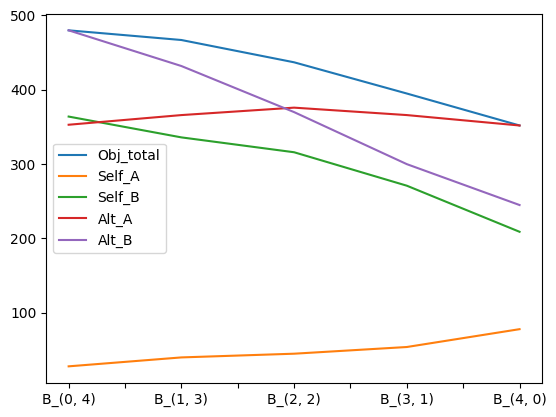

In [ ]:
table_non_alt.transpose().plot()

In [ ]:
table_non_alt

,"B_(0, 4)","B_(1, 3)","B_(2, 2)","B_(3, 1)","B_(4, 0)"
Obj_total,480,467,437,395,352
Self_A,28,40,45,54,78
Self_B,364,336,316,271,209
Alt_A,353,366,376,366,352
Alt_B,480,432,370,300,245


In [ ]:
table = {}

for B in B_set:
    N = B[0]+B[1]
    table['B_%s'%str(B)] = [df_result_alt[B].iloc[N,5], df_result_alt[B].iloc[N+1,1], df_result_alt[B].iloc[N+1,3], df_result_alt[B].iloc[N,1], df_result_alt[B].iloc[N,3]]

table_alt = pd.DataFrame(table, index=['Obj_total','Self_A','Self_B','Alt_A', 'Alt_B'])

<Axes: >

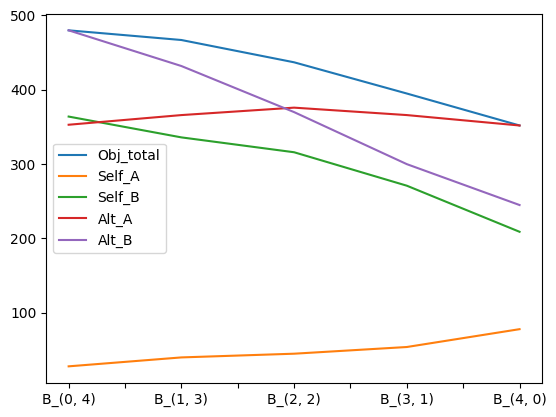

In [ ]:
table_alt.transpose().plot()

In [ ]:
table_alt

,"B_(0, 4)","B_(1, 3)","B_(2, 2)","B_(3, 1)","B_(4, 0)"
Obj_total,480,467,437,395,352
Self_A,28,40,45,54,78
Self_B,364,336,316,271,209
Alt_A,353,366,376,366,352
Alt_B,480,432,370,300,245


In [ ]:
table = {}

for B in B_set:
    N = B[0]+B[1]
    table['B_%s'%str(B)] = [df_result_non_self[B].iloc[N+1,1] + df_result_non_self[B].iloc[N+1,3], df_result_non_self[B].iloc[N+1,1], df_result_non_self[B].iloc[N+1,3]]

table_non_self = pd.DataFrame(table, index=['Selfish','Self_A','Self_B'])

<Axes: >

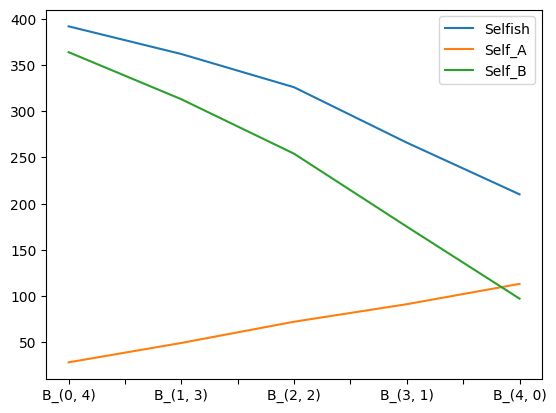

In [ ]:
table_non_self.transpose().plot()

In [ ]:
table_non_self

,"B_(0, 4)","B_(1, 3)","B_(2, 2)","B_(3, 1)","B_(4, 0)"
Selfish,392,362,326,266,210
Self_A,28,49,72,91,113
Self_B,364,313,254,175,97


In [ ]:
table = {}

for B in B_set:
    N = B[0]+B[1]
    table['B_%s'%str(B)] = [df_result_self[B].iloc[N+1,1] + df_result_self[B].iloc[N+1,3], df_result_self[B].iloc[N+1,1], df_result_self[B].iloc[N+1,3]]

table_self = pd.DataFrame(table, index=['Selfish','Self_A','Self_B'])

<Axes: >

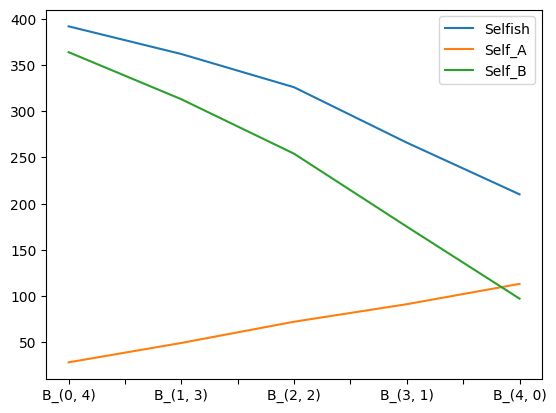

In [ ]:
table_self.transpose().plot()

In [ ]:
table_self

,"B_(0, 4)","B_(1, 3)","B_(2, 2)","B_(3, 1)","B_(4, 0)"
Selfish,392,362,326,266,210
Self_A,28,49,72,91,113
Self_B,364,313,254,175,97


In [ ]:
with pd.ExcelWriter(path+'/Transfer_%d/table.xlsx'%(K)) as writer:
    table_whole.to_excel(writer, sheet_name='table_global')
    table_non_alt.to_excel(writer, sheet_name='table_non_alt')
    table_non_self.to_excel(writer, sheet_name='table_non_self')
    table_alt.to_excel(writer, sheet_name='table_alt')
    table_self.to_excel(writer, sheet_name='table_self')